In [6]:
getwd(); setwd("/home/garret/Documents/R code/SCENIC/SCENIC_HB_neuron")

[1] "/home/garret/Documents/R code/SCENIC/SCENIC_HB_neuron"

In [7]:
library(Seurat)
library(dplyr)
library(magrittr)
IRdisplay::display_html("<style> .container { width:95% !important; } </style>")
library("ggplot2")
library("xlsx")
library(tools)
library("reshape2")
library(data.table)

library(SingleCellExperiment)

In [8]:
LHb.integrated<-readRDS(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/LHb_integrated_0.8.rds")
cntl<-readRDS("/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/cntl_0.8.rds")
stim<-readRDS("/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/stim_0.8.rds")

In [9]:
load("data/sceMouseBrain.RData")
library(SCENIC)
exprMat <- counts(sceMouseBrain) 
# Optional: log expression (for TF expression plot, it does not affect any other calculation)
#exprMat <- log2(exprMat+1)
dim(exprMat)
library(SCENIC)
library("BiocParallel") # require function "register"
scenicOptions <- readRDS("int/scenicOptions.Rds")
scenicOptions@settings$verbose <- TRUE
scenicOptions@settings$nCores <- 6# defauexprMat <- counts(sceMouseBrain) 
dim(exprMat)
library(SCENIC)
library("BiocParallel") # require function "register"
scenicOptions <- readRDS("int/scenicOptions.Rds")
scenicOptions@settings$verbose # lt is 20 
scenicOptions@settings$seed <- 123
library(BiocParallel) 
registered()
regulons <- loadInt(scenicOptions, "regulons")

[1] 17726  5558

[1] 17726  5558

[1] TRUE

$MulticoreParam
class: MulticoreParam
  bpisup: FALSE; bpnworkers: 10; bptasks: 0; bpjobname: BPJOB
  bplog: FALSE; bpthreshold: INFO; bpstopOnError: TRUE
  bpRNGseed: ; bptimeout: 2592000; bpprogressbar: FALSE
  bpexportglobals: TRUE
  bplogdir: NA
  bpresultdir: NA
  cluster type: FORK

$SnowParam
class: SnowParam
  bpisup: FALSE; bpnworkers: 10; bptasks: 0; bpjobname: BPJOB
  bplog: FALSE; bpthreshold: INFO; bpstopOnError: TRUE
  bpRNGseed: ; bptimeout: 2592000; bpprogressbar: FALSE
  bpexportglobals: TRUE
  bplogdir: NA
  bpresultdir: NA
  cluster type: SOCK

$SerialParam
class: SerialParam
  bpisup: FALSE; bpnworkers: 1; bptasks: 0; bpjobname: BPJOB
  bplog: FALSE; bpthreshold: INFO; bpstopOnError: TRUE
  bpRNGseed: ; bptimeout: 2592000; bpprogressbar: FALSE
  bpexportglobals: TRUE
  bplogdir: NA
  bpresultdir: NA


In [10]:
regulons$Fos
length(regulons$Fos)

[1] "Hgs"    "Hmga1"  "Ifrd1"  "Lmna"   "Mid1"   "Mpv17"  "Ndrg1"  "Ociad2"
 [9] "Sh2d5"  "Stk40"

[1] 10

# assgin clusters to cell types

In [11]:
new.ident <- c("MHb1","MHb2","MHb3","LHb1","LHb2","LHb3","MHb4","LHb4","MHb5","LHb5","LHb6","MHb6","Surr1","Surr2","Surr3","Surr4")
names(x = new.ident) <- levels(x =LHb.integrated)
LHb.integrated<- RenameIdents(object =LHb.integrated, new.ident)

In [12]:
for (i in 1:length(new.ident)){
assign(paste(new.ident[i],"_barcode",sep=""),colnames(LHb.integrated@assays$RNA@data[,which(Idents(object=LHb.integrated) %in% new.ident[i])]))# this gives all barcodes in cluster
assign(paste(new.ident[i],"_barcode_cntl",sep=""),intersect(colnames(cntl@assays$RNA@data),eval(parse(text = paste(new.ident[i],"_barcode",sep="")))))
assign(paste(new.ident[i],"_barcode_stim",sep=""),intersect(colnames(stim@assays$RNA@data),eval(parse(text = paste(new.ident[i],"_barcode",sep="")))))}

In [13]:
LHb.integrated<-subset(x=LHb.integrated,cells=c(MHb1_barcode,MHb2_barcode,MHb3_barcode,LHb1_barcode,LHb2_barcode,LHb3_barcode,MHb4_barcode,MHb5_barcode,LHb4_barcode,LHb5_barcode,MHb6_barcode,LHb6_barcode))

# TFs regulating markers in LHB vs MHb

In [14]:
MHb_gene<-read.xlsx("/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/class_genes/conserved_markers_MHB_overLHbgene_eachcombined.xlsx",sheetIndex=1)     
LHb_gene<-read.xlsx("/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/class_genes/conserved_markers_LHB_overMHbgene_eachcombined.xlsx",sheetIndex=1)  

In [15]:
MHb_gene<-as.character(MHb_gene[,1])
LHb_gene<-as.character(LHb_gene[,1])

In [16]:
length(MHb_gene)
length(LHb_gene)

[1] 170

[1] 289

In [17]:
# careful with [[]]
unique_gene<-unique(MHb_gene)
M.TF.list<-list()
for (j in 1:length(unique_gene)){
GOI<-unique_gene[j]
temp<-vector(mode="character", length=0)
for (i in 1:length(regulons)){if (GOI %in% regulons[[i]]){temp<-c(temp,names(regulons[i]))}}
if (length(temp)==0){M.TF.list[[GOI]]<-"None"}else{M.TF.list[[GOI]]<-temp}  }

In [18]:
# careful with [[]]
unique_gene<-unique(LHb_gene)
L.TF.list<-list()
for (j in 1:length(unique_gene)){
GOI<-unique_gene[j]
temp<-vector(mode="character", length=0)
for (i in 1:length(regulons)){if (GOI %in% regulons[[i]]){temp<-c(temp,names(regulons[i]))}}
if (length(temp)==0){L.TF.list[[GOI]]<-"None"}else{L.TF.list[[GOI]]<-temp}  }

In [19]:
M.TFs<-vector(mode="character", length=0)
for (i in 1:length(M.TF.list)){
    if (M.TF.list[[i]]=="None"){M.TFs<-M.TFs}else{M.TFs<-c(M.TFs,M.TF.list[[i]])}
}
L.TFs<-vector(mode="character", length=0)
for (i in 1:length(L.TF.list)){
    if (L.TF.list[[i]]=="None"){L.TFs<-L.TFs}else{L.TFs<-c(L.TFs,L.TF.list[[i]])}
}

Warning message in if (M.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (M.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (M.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (M.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (M.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (M.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (M.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (M.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (M

“the condition has length > 1 and only the first element will be used”Warning message in if (M.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (M.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (M.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (M.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (M.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (M.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (M.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (M.TF.list[[i]] == "None") {:
“the condition has lengt

“the condition has length > 1 and only the first element will be used”Warning message in if (M.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (M.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (M.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (M.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (M.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (M.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (L.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (L.TF.list[[i]] == "None") {:
“the condition has lengt

“the condition has length > 1 and only the first element will be used”Warning message in if (L.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (L.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (L.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (L.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (L.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (L.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (L.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (L.TF.list[[i]] == "None") {:
“the condition has lengt

“the condition has length > 1 and only the first element will be used”Warning message in if (L.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (L.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (L.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (L.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (L.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (L.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (L.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (L.TF.list[[i]] == "None") {:
“the condition has lengt

“the condition has length > 1 and only the first element will be used”Warning message in if (L.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (L.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (L.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (L.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (L.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (L.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (L.TF.list[[i]] == "None") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (L.TF.list[[i]] == "None") {:
“the condition has lengt

In [20]:
M.TFs<-as.data.frame(table(M.TFs))
M.TFs_order<-M.TFs[order(-M.TFs$Freq),]

In [21]:
rownames(M.TFs_order)<-as.character(M.TFs_order[,1])

In [22]:
nonDEG<-vector(mode="numeric", length=0)
DEGenrichment<-vector(mode="numeric", length=0)
for (i in 1:dim(M.TFs_order)[1]){
nonDEG[i]<- length(regulons[[rownames(M.TFs_order)[i]]]) - M.TFs_order$Freq[i]
DEGenrichment[i]<-   M.TFs_order$Freq[i]/length(regulons[[rownames(M.TFs_order)[i]]])
}
M.TFs_order$nonDEG<-nonDEG
M.TFs_order$DEGenrichment<-DEGenrichment
colnames(M.TFs_order)[2]<-"DEG"
rownames(M.TFs_order)<-M.TFs_order$M.TFs
M.TFs_order<-M.TFs_order[order(M.TFs_order$DEGenrichment),]# you may reverse order if normoal bar graph
M.TFs_order$M.TFs<-factor(M.TFs_order$M.TFs,levels=as.character(M.TFs_order$M.TFs))
write.xlsx2(M.TFs_order,file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/class_genes/MTF_rank_MHbrichgenes.xlsx")

In [23]:
dim(M.TFs_order)

[1] 105   4

In [24]:
#use this. This is remove the TFs if if has extended
remove<-numeric()
for (i in 1:dim(M.TFs_order)[1]){
if(paste(M.TFs_order[,1][i],"_extended",sep="") %in% M.TFs_order[,1]){
    remove<-c(remove,i)}else{remove<-remove}
}
M.TFs_order<-M.TFs_order[-remove,]

In [29]:
M.TFs_order

,M.TFs,DEG,nonDEG,DEGenrichment
Gtf2f1_extended,Gtf2f1_extended,1,1184,0.0008438819
Bmyc_extended,Bmyc_extended,3,1944,0.0015408320
Ets2_extended,Ets2_extended,1,644,0.0015503876
Ep300_extended,Ep300_extended,2,1166,0.0017123288
Setdb1_extended,Setdb1_extended,1,424,0.0023529412
Elk1_extended,Elk1_extended,1,390,0.0025575448
E2f4_extended,E2f4_extended,1,385,0.0025906736
E2f6_extended,E2f6_extended,5,1882,0.0026497085
Zfp369_extended,Zfp369_extended,2,682,0.0029239766
Zeb1_extended,Zeb1_extended,1,332,0.0030030030


In [25]:
dim(M.TFs_order)

[1] 78  4

Warning message:
“Removed 12 rows containing missing values (geom_point).”

Warning message:
“Removed 12 rows containing missing values (geom_point).”

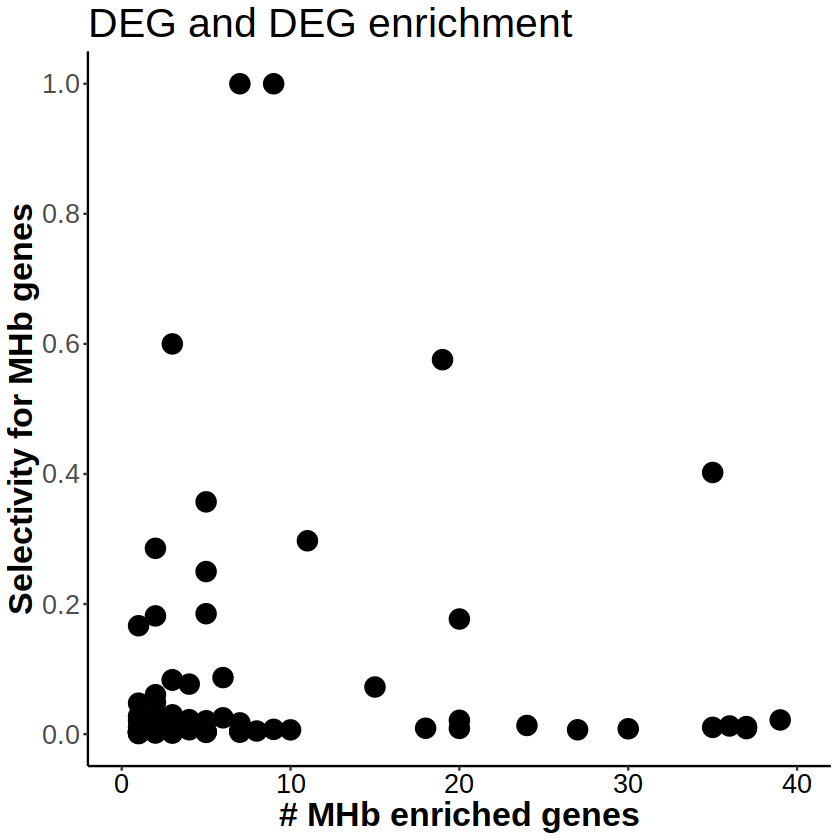

In [34]:
ggplot(M.TFs_order,aes(x=DEG,y=DEGenrichment))+geom_point(stat = "identity",size=5)+xlab("# MHb enriched genes")+ylab("Selectivity for MHb genes")+ scale_y_continuous(breaks=seq(0,1.0,0.2))+theme(axis.text.x=element_text(size=16,color="black"),axis.text.y=element_text(size=16,hjust = 1),axis.title=element_text(size=20,face="bold"),plot.title = element_text(size=24),,panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))+xlim(0,40)+ggtitle("DEG and DEG enrichment")
#+xlab("TF")+ylab("DEG enrichment")+theme(axis.text.x=element_text(size=10,angle = 50, hjust = 1))+ggtitle("correlation_DEG_Ar") 
             
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/class_genes/MHb_TFs_scatter_tight.pdf",width=15,height=10)

In [59]:
write.xlsx2(M.TFs_order,file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/class_genes/MTF_rank_MHbrichgenes_tight.xlsx")

In [26]:
L.TFs<-as.data.frame(table(L.TFs))
L.TFs_order<-L.TFs[order(-L.TFs$Freq),]
rownames(L.TFs_order)<-as.character(L.TFs_order[,1])
nonDEG<-vector(mode="numeric", length=0)
DEGenrichment<-vector(mode="numeric", length=0)
for (i in 1:dim(L.TFs_order)[1]){
nonDEG[i]<- length(regulons[[rownames(L.TFs_order)[i]]]) - L.TFs_order$Freq[i]
DEGenrichment[i]<-   L.TFs_order$Freq[i]/length(regulons[[rownames(L.TFs_order)[i]]])
}
L.TFs_order$nonDEG<-nonDEG
L.TFs_order$DEGenrichment<-DEGenrichment
colnames(L.TFs_order)[2]<-"DEG"
rownames(L.TFs_order)<-L.TFs_order$L.TFs
L.TFs_order<-L.TFs_order[order(L.TFs_order$DEGenrichment),]
L.TFs_order$L.TFs<-factor(L.TFs_order$L.TFs,levels=as.character(L.TFs_order$L.TFs))
write.xlsx2(M.TFs_order,file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/class_genes/MTF_rank_MHbrichgenes.xlsx")

In [27]:
remove<-numeric()
for (i in 1:dim(L.TFs_order)[1]){
if(paste(L.TFs_order[,1][i],"_extended",sep="") %in% L.TFs_order[,1]){
    remove<-c(remove,i)}else{remove<-remove}
}
L.TFs_order<-L.TFs_order[-remove,]

Warning message:
“Removed 26 rows containing missing values (geom_point).”

Warning message:
“Removed 26 rows containing missing values (geom_point).”

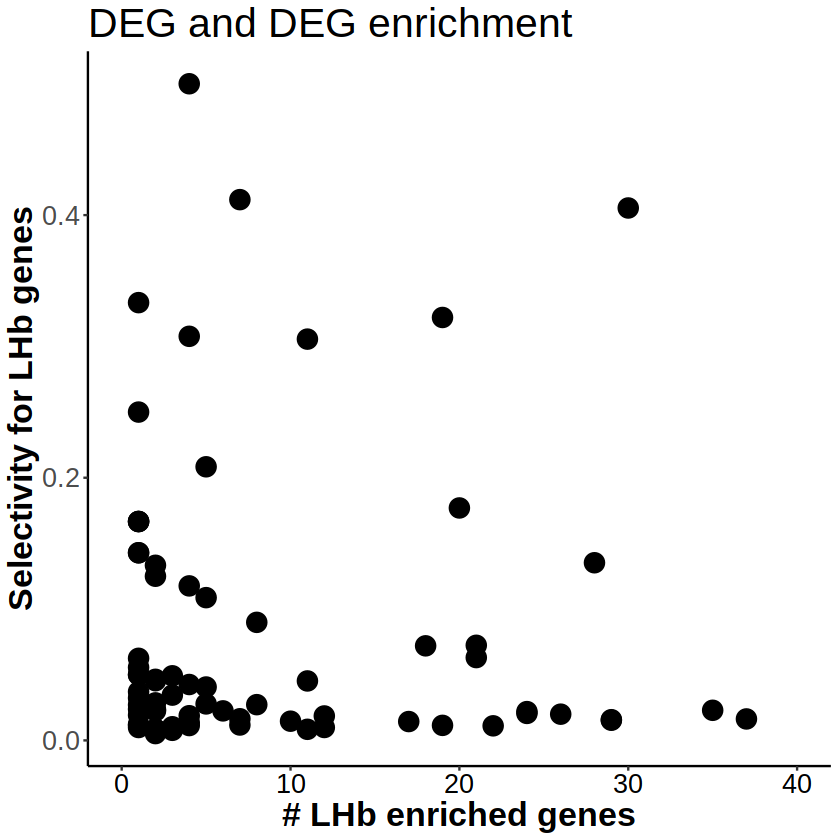

In [42]:
ggplot(L.TFs_order,aes(x=DEG,y=DEGenrichment))+geom_point(stat = "identity" ,size=5)+xlab("# LHb enriched genes")+ylab("Selectivity for LHb genes")+ scale_y_continuous(breaks=seq(0,0.6,0.2))+theme(axis.text.x=element_text(size=16,color="black"),axis.text.y=element_text(size=16,hjust = 1),axis.title=element_text(size=20,face="bold"),plot.title = element_text(size=24),,panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))+xlim(0,40)+ggtitle("DEG and DEG enrichment")
#+xlab("TF")+ylab("DEG enrichment")+theme(axis.text.x=element_text(size=10,angle = 50, hjust = 1))+ggtitle("correlation_DEG_Ar") 
             
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/class_genes/LHb_TFs_scatter_tight.pdf",width=15,height=10)

In [58]:
write.xlsx2(L.TFs_order,file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/class_genes/LTF_rank_LHbrichgenes_tight.xlsx")

# testing coverage of marker genes by TFs

In [28]:
M.TFs_order<-M.TFs_order[rev(order(M.TFs_order$DEGenrichment)),]

In [29]:
M.TFs_order

,M.TFs,DEG,nonDEG,DEGenrichment
Gpd1,Gpd1,7,0,1.00000000
Neurod1_extended,Neurod1_extended,9,0,1.00000000
Irx3_extended,Irx3_extended,3,2,0.60000000
Neurod2_extended,Neurod2_extended,19,14,0.57575758
Pou3f1_extended,Pou3f1_extended,35,52,0.40229885
Lef1_extended,Lef1_extended,5,9,0.35714286
Ebf1,Ebf1,11,26,0.29729730
Sox6,Sox6,2,5,0.28571429
Pbx3_extended,Pbx3_extended,5,15,0.25000000
Pou3f3_extended,Pou3f3_extended,5,22,0.18518519


In [31]:
cumulative<-numeric()
genes<-numeric()
for (i in 1:dim(M.TFs_order)[1]){
    genes<-unique(c(genes,intersect(regulons[[as.character(M.TFs_order[i,1])]],MHb_gene)))
    cumulative<-c(cumulative,length(genes))
}
cumulative<-(100/max(cumulative))*cumulative

In [32]:
M_coverage<-data.frame(TFs=M.TFs_order[,1],cumulative=cumulative)
M_coverage$TFs<-factor(M_coverage$TFs,levels=M_coverage$TFs)

In [33]:
cumulative

[1]   4.605263  10.526316  11.842105  19.078947  30.263158  31.578947
 [7]  32.894737  32.894737  34.868421  35.526316  35.526316  42.763158
[13]  42.763158  44.736842  44.736842  46.710526  48.026316  50.000000
[19]  50.000000  51.315789  51.315789  52.631579  53.289474  53.289474
[25]  53.289474  63.157895  63.157895  71.052632  76.315789  76.315789
[31]  77.631579  77.631579  80.263158  86.184211  86.184211  90.131579
[37]  94.078947  94.078947  97.368421  97.368421  97.368421  97.368421
[43]  97.368421  98.026316  98.026316  98.026316  98.026316  98.684211
[49]  98.684211  98.684211  98.684211  98.684211  98.684211  98.684211
[55]  99.342105  99.342105  99.342105  99.342105  99.342105  99.342105
[61]  99.342105 100.000000 100.000000 100.000000 100.000000 100.000000
[67] 100.000000 100.000000 100.000000 100.000000 100.000000 100.000000
[73] 100.000000 100.000000 100.000000 100.000000 100.000000 100.000000

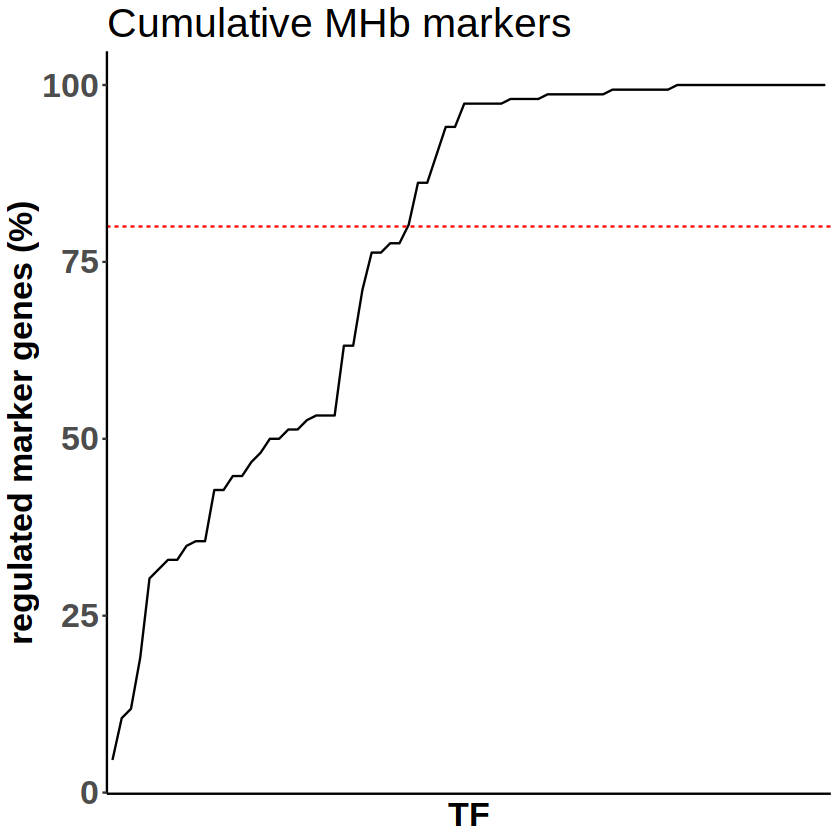

In [196]:
ggplot(data=M_coverage, aes(x=TFs, y=cumulative,group=1)) +geom_line()+xlab("TF")+ylab("regulated marker genes (%)")+geom_hline(yintercept=80, linetype="dashed", color = "red")+
theme(axis.text.x=element_blank(),axis.text.y=element_text(size=20,face="bold",hjust = 1),axis.title=element_text(size=20,face="bold"),plot.title = element_text(size=24),,panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
axis.ticks.x=element_blank(),panel.background = element_blank(), axis.line = element_line(colour = "black"))+ggtitle("Cumulative MHb markers")
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/class_genes/MHb_cumulative.pdf",width=12,height=10)

In [34]:
intersect(M.TFs_order[,1][1:33],L.TFs_order[,1][1:33])
length(intersect(M.TFs_order[,1],L.TFs_order[,1]))
length(M.TFs_order[,1])
length(L.TFs_order[,1])

[1] "Pou3f1_extended" "Ybx1_extended"   "Etv5_extended"

[1] 62

[1] 78

[1] 100

In [35]:
cumulative[33]
#M: 78, overlap is 62, but till 33 only 3

[1] 80.26316

In [36]:
L.TFs_order<-L.TFs_order[rev(order(L.TFs_order$DEGenrichment)),]

In [37]:
cumulative<-numeric()
genes<-numeric()
for (i in 1:dim(L.TFs_order)[1]){
    genes<-unique(c(genes,intersect(regulons[[as.character(L.TFs_order[i,1])]],LHb_gene)))
    cumulative<-c(cumulative,length(genes))
}
cumulative<-(100/max(cumulative))*cumulative

In [38]:
L_coverage<-data.frame(TFs=L.TFs_order[,1],cumulative=cumulative)
L_coverage$TFs<-factor(L_coverage$TFs,levels=L_coverage$TFs)

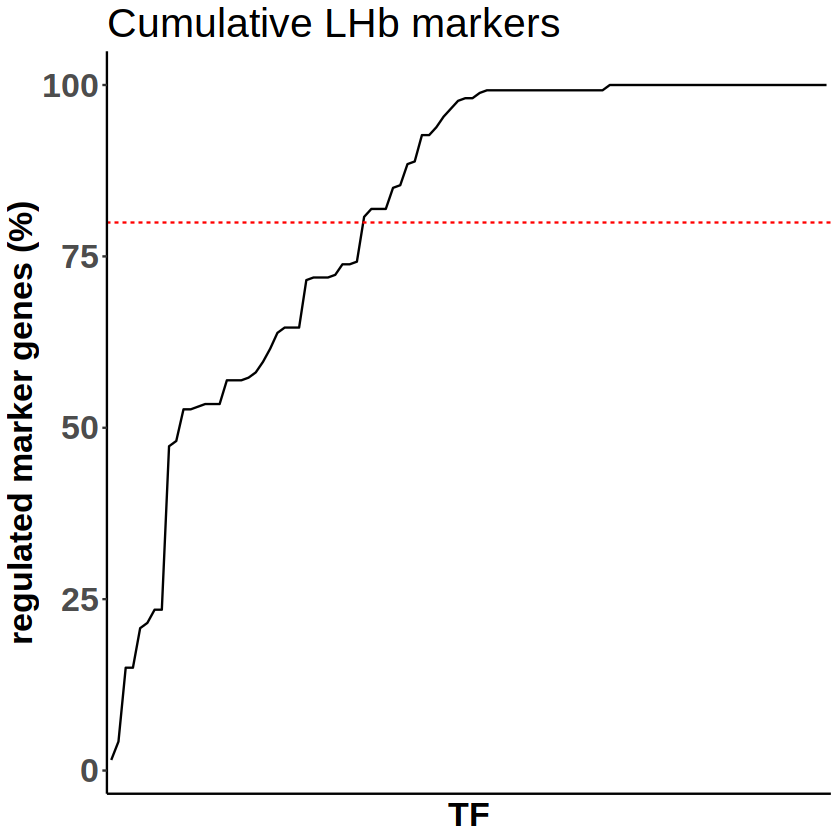

In [193]:
ggplot(data=L_coverage, aes(x=TFs, y=cumulative,group=1)) +geom_line()+xlab("TF")+ylab("regulated marker genes (%)")+geom_hline(yintercept=80, linetype="dashed", color = "red")+
theme(axis.text.x=element_blank(),axis.text.y=element_text(size=20,face="bold",hjust = 1),axis.title=element_text(size=20,face="bold"),plot.title = element_text(size=24),,panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
axis.ticks.x=element_blank(),panel.background = element_blank(), axis.line = element_line(colour = "black"))+ggtitle("Cumulative LHb markers")
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/class_genes/LHb_cumulative.pdf",width=12,height=10)

In [39]:
cumulative[36] # has 100

[1] 80.76923

In [40]:
intersect(M.TFs_order[,1][1:33],L.TFs_order[,1][1:36])

[1] "Pbx3_extended"   "Tcf7l2"          "Zic4_extended"   "Zic1"           
[5] "Pou2f2_extended" "Tef_extended"    "Npdc1_extended"  "Jund_extended"  
[9] "Crebl2_extended"

# genes regulated by top regulons

In [199]:
head(M.TFs_order)
head(L.TFs_order)

,M.TFs,DEG,nonDEG,DEGenrichment
Gpd1,Gpd1,7,0,1.0000000
Neurod1_extended,Neurod1_extended,9,0,1.0000000
Irx3_extended,Irx3_extended,3,2,0.6000000
Neurod2_extended,Neurod2_extended,19,14,0.5757576
Pou3f1_extended,Pou3f1_extended,35,52,0.4022989
Lef1_extended,Lef1_extended,5,9,0.3571429


,L.TFs,DEG,nonDEG,DEGenrichment
Pou3f2,Pou3f2,4,4,0.5000000
Zfhx2_extended,Zfhx2_extended,7,10,0.4117647
Pou2f2_extended,Pou2f2_extended,30,44,0.4054054
Tead1,Tead1,1,2,0.3333333
Esrrg_extended,Esrrg_extended,19,40,0.3220339
Ar,Ar,4,9,0.3076923


In [216]:
M.TFs_order[1:5,1]
intersect(regulons[[as.character(M.TFs_order[1,1])]],MHb_gene)
intersect(regulons[[as.character(M.TFs_order[2,1])]],MHb_gene)
intersect(regulons[[as.character(M.TFs_order[3,1])]],MHb_gene)
intersect(regulons[[as.character(M.TFs_order[4,1])]],MHb_gene)
intersect(regulons[[as.character(M.TFs_order[5,1])]],MHb_gene)

[1] Gpd1             Neurod1_extended Irx3_extended    Neurod2_extended
[5] Pou3f1_extended 
105 Levels: Gtf2f1_extended Nfyb Bmyc_extended Ets2_extended ... Neurod1

[1] "6030419C18Rik" "Adam11"        "Gdpd5"         "Impdh1"       
[5] "Lsp1"          "Pde2a"         "Plch2"

[1] "A830010M20Rik" "Gabbr2"        "Gfra1"         "Kcnip1"       
[5] "Neurod1"       "Nr4a2"         "Rgs6"          "St6galnac5"   
[9] "Tmem56"

[1] "Lmo3"    "Lsp1"    "Rapgef4"

[1] "3632451O06Rik" "6030419C18Rik" "A830010M20Rik" "Adam11"       
 [5] "Ano3"          "Chat"          "Fgf1"          "Gdpd5"        
 [9] "Impdh1"        "Klf13"         "Lhfp"          "Lmo3"         
[13] "Napb"          "Plch2"         "Rbfox3"        "Rgs6"         
[17] "Slc18a3"       "Tgfb2"         "Zdhhc18"

[1] "3632451O06Rik" "6030419C18Rik" "A830010M20Rik" "Adam11"       
 [5] "Ano3"          "Cadps2"        "Celf2"         "Chat"         
 [9] "Chst2"         "Coro2b"        "Cpne4"         "Etv1"         
[13] "Fgf1"          "Fzd7"          "Gdpd5"         "Gfra1"        
[17] "Gnal"          "Kcnd2"         "Kcnip3"        "Lix1"         
[21] "Lmo3"          "Nr4a2"         "Pde2a"         "Pld5"         
[25] "Ppp1r1b"       "Rbfox3"        "Rgs6"          "Robo3"        
[29] "Slc18a3"       "Snca"          "St6galnac5"    "Tac2"         
[33] "Tgfb2"         "Tmem56"        "Zic1"

In [217]:
L.TFs_order[1:5,1]
intersect(regulons[[as.character(L.TFs_order[1,1])]],LHb_gene)
intersect(regulons[[as.character(L.TFs_order[2,1])]],LHb_gene)
intersect(regulons[[as.character(L.TFs_order[3,1])]],LHb_gene)
intersect(regulons[[as.character(L.TFs_order[4,1])]],LHb_gene)
intersect(regulons[[as.character(L.TFs_order[5,1])]],LHb_gene)

[1] Pou3f2          Zfhx2_extended  Pou2f2_extended Tead1          
[5] Esrrg_extended 
133 Levels: E2f4_extended Etv3 Gabpa Elk1 Elk1_extended ... Pou3f2

[1] "Fxyd6" "Hpca"  "Nr2f1" "Nrxn3"

[1] "Bhlhe40" "Elavl2"  "Lgi2"    "Tpbg"    "Tuba1b"  "Vamp1"   "Zfhx4"

[1] "Ahi1"     "Cacna1g"  "Camk2a"   "Cd47"     "Cntnap5a" "Csrnp3"  
 [7] "Dlgap1"   "Elavl2"   "Elmod1"   "Fam19a2"  "Fign"     "Fut9"    
[13] "Gnaq"     "Hpca"     "Kcnip4"   "Mal2"     "Mast4"    "Ncam1"   
[19] "Ntng1"    "Ntrk2"    "Pak1"     "Pcdh10"   "Pcdh19"   "Pcdh7"   
[25] "Plxna4"   "Runx1t1"  "Sox1"     "Spats2l"  "Tshz2"    "Zfhx3"

[1] "Mal2"

[1] "Adcyap1r1" "Atp2b2"    "Caln1"     "Ckmt1"     "Gabra1"    "Hcn2"     
 [7] "Kcnip4"    "Kcnj3"     "Lingo1"    "Nat8l"     "Nr2f2"     "Nrxn3"    
[13] "Pde1b"     "Plxna4"    "Rnf152"    "Slc24a3"   "Sorl1"     "Spats2l"  
[19] "Stxbp6"

# combinatorial regulation of TFs

In [83]:
MHb_gene[1] %in% regulons[[MHb_TF[1]]]

[1] FALSE

In [73]:
length(MHb_gene)
MHb_TF<-as.character(rownames(M.TFs_order))

[1] 170

In [85]:
number_TFs<-numeric()
for (i in 1: length(MHb_gene)){
    temp<-0
    for (j in 1: length(MHb_TF)){
        if (sum(MHb_gene[i] %in% regulons[[MHb_TF[j]]])){
            temp<-temp+1
        }else{temp<-temp}
    }
    number_TFs[i]<-temp
}

In [89]:
sum(number_TFs>0)
sum(number_TFs>1)

[1] 152

[1] 140

In [93]:
140/152
140/length(MHb_gene)

[1] 0.9210526

[1] 0.8235294

In [90]:
LHb_TF<-as.character(rownames(L.TFs_order))
number_TFs<-numeric()
for (i in 1: length(LHb_gene)){
    temp<-0
    for (j in 1: length(LHb_TF)){
        if (sum(LHb_gene[i] %in% regulons[[LHb_TF[j]]])){
            temp<-temp+1
        }else{temp<-temp}
    }
    number_TFs[i]<-temp
}
sum(number_TFs>0)
sum(number_TFs>1)

[1] 260

[1] 251

In [94]:
251/260
251/length(LHb_gene)

[1] 0.9653846

[1] 0.8685121

# disc plot visualization of TFs

In [3]:
library(scales)

In [13]:
#TFs MHb
Cell_type<-factor(rev(c("MHb3","MHb6","MHb4","MHb5","MHb1","MHb2")),levels=rev(c("MHb3","MHb6","MHb4","MHb5","MHb1","MHb2")))
gene_list<-rev(c("Neurod1" ,"Gpd1" ,"Pou3f1","Neurod2" ,"Irx3","Lef1","Ebf1","Sox6","Pbx3","Pou3f3","Nfib","Tcf7l2","Zic4","Klf9","Tcf7","Lhx9","Ybx1","Zic1","Mxd4","Myef2","Nfix","Klf7","E4f1","Pou2f2","Etv5","Foxp2","Bhlhe41","Usf2","Tef","Npdc1","Jund","Crebl2","Etv1"))

In [14]:
Cell_number<- data.frame(Date=as.Date(character()),File=character(),User=character(),stringsAsFactors=FALSE)

for (i in 1:length(gene_list)){
L<-length(Cell_type)

Cell_number_t<- data.frame("cluster" =Cell_type, "gene"=c(rep(gene_list[i],L)))
#used normalized uncorrected data
for (p in 1:length(Cell_type)){
Cell_number_t$pct[p]<-100*sum(LHb.integrated@assays$RNA@data[gene_list[i],eval(parse(text=paste(Cell_type[p],"_barcode",sep="")))]>0)/length(eval(parse(text=paste(Cell_type[p],"_barcode",sep=""))))
Cell_number_t$avg[p]<-(mean(LHb.integrated@assays$RNA@data[gene_list[i],eval(parse(text=paste(Cell_type[p],"_barcode",sep="")))])-mean(LHb.integrated@assays$RNA@data[gene_list[i],]))/sd(LHb.integrated@assays$RNA@data[gene_list[i],])
#for avg only consider the expressed cell
 #t<-LHb.integrated@assays$RNA@data[gene_list[i],eval(parse(text=paste(Cell_type[p],"_barcode",sep="")))]>0
# Cell_number_t$avg[p]<-mean(LHb.integrated@assays$RNA@data[gene_list[i],t])/sd(LHb.integrated@assays$RNA@data[gene_list[i],eval(parse(text=paste(Cell_type[p],"_barcode",sep="")))])    
    }
Cell_number<-rbind(Cell_number_t,Cell_number)}
as.factor(Cell_number$cluster)

[1] MHb2 MHb1 MHb5 MHb4 MHb6 MHb3 MHb2 MHb1 MHb5 MHb4 MHb6 MHb3 MHb2 MHb1 MHb5
 [16] MHb4 MHb6 MHb3 MHb2 MHb1 MHb5 MHb4 MHb6 MHb3 MHb2 MHb1 MHb5 MHb4 MHb6 MHb3
 [31] MHb2 MHb1 MHb5 MHb4 MHb6 MHb3 MHb2 MHb1 MHb5 MHb4 MHb6 MHb3 MHb2 MHb1 MHb5
 [46] MHb4 MHb6 MHb3 MHb2 MHb1 MHb5 MHb4 MHb6 MHb3 MHb2 MHb1 MHb5 MHb4 MHb6 MHb3
 [61] MHb2 MHb1 MHb5 MHb4 MHb6 MHb3 MHb2 MHb1 MHb5 MHb4 MHb6 MHb3 MHb2 MHb1 MHb5
 [76] MHb4 MHb6 MHb3 MHb2 MHb1 MHb5 MHb4 MHb6 MHb3 MHb2 MHb1 MHb5 MHb4 MHb6 MHb3
 [91] MHb2 MHb1 MHb5 MHb4 MHb6 MHb3 MHb2 MHb1 MHb5 MHb4 MHb6 MHb3 MHb2 MHb1 MHb5
[106] MHb4 MHb6 MHb3 MHb2 MHb1 MHb5 MHb4 MHb6 MHb3 MHb2 MHb1 MHb5 MHb4 MHb6 MHb3
[121] MHb2 MHb1 MHb5 MHb4 MHb6 MHb3 MHb2 MHb1 MHb5 MHb4 MHb6 MHb3 MHb2 MHb1 MHb5
[136] MHb4 MHb6 MHb3 MHb2 MHb1 MHb5 MHb4 MHb6 MHb3 MHb2 MHb1 MHb5 MHb4 MHb6 MHb3
[151] MHb2 MHb1 MHb5 MHb4 MHb6 MHb3 MHb2 MHb1 MHb5 MHb4 MHb6 MHb3 MHb2 MHb1 MHb5
[166] MHb4 MHb6 MHb3 MHb2 MHb1 MHb5 MHb4 MHb6 MHb3 MHb2 MHb1 MHb5 MHb4 MHb6 MHb3
[181] MHb2 MHb1 MHb5 MHb4 MHb6 MHb3 MHb2 MHb1 MHb5 MHb4 MHb6 MHb3 MHb2 MHb1 MHb5
[196] MHb4 MHb6 MHb3
Levels: MHb2 MHb1 MHb5 MHb4 MHb6 MHb3

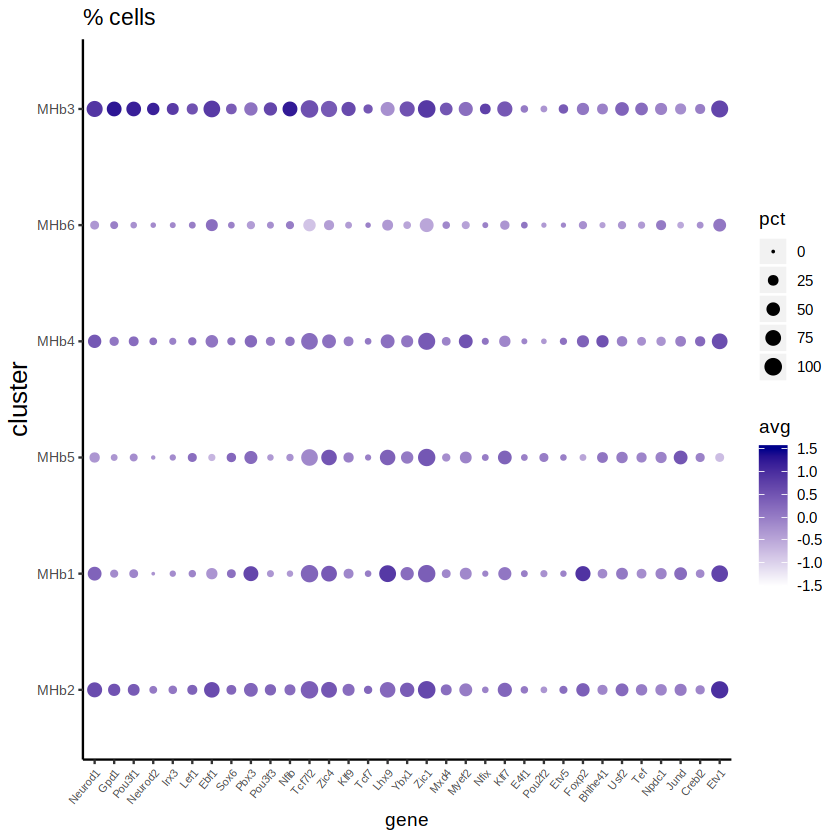

In [15]:
ggplot(Cell_number, aes(gene, cluster)) + geom_point(aes(size = pct, colour=avg)) + 
scale_color_gradient(low = "white", high = "darkblue",limits = c(-1.5,1.5),oob=squish) + 
geom_point(aes(size = pct), pch=21,, lwd=0,stroke=0)+ scale_size_continuous(range = c(0,3.9))+
theme(axis.title.y=element_text(size=15),axis.text.y=element_text(size=8),axis.text.x=element_text(size=6,angle = 50, hjust = 1),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))+ggtitle("% cells")
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/discplots_TF_MHb.pdf",height=4, width=10 , paper = "letter")

In [16]:
#TFs LHb
Cell_type<-factor(rev(c("LHb2","LHb1","LHb3","LHb6","LHb4","LHb5")),levels=rev(c("LHb2","LHb1","LHb3","LHb6","LHb4","LHb5")))
gene_list<-rev(c("Pou3f2" ,"Zfhx2","Pou2f2" ,"Tead1" ,"Esrrg","Ar","Shox2","Gtf3c2","Ppargc1a","Hlf","Tcf7l2","Zic4","Trps1","Cebpz","Zbtb7a","Rora","Zic1","Nfia","Tbl1xr1","Onecut2","Npdc1","Rfx3","Meis3","Jun","Zeb1","Foxn3","Mga","Tef","Pbx3","Foxk1","Ezh2","Atf2","Jund","Zfp35","Crebl2","Bmyc"))

In [17]:
Cell_number<- data.frame(Date=as.Date(character()),File=character(),User=character(),stringsAsFactors=FALSE)

for (i in 1:length(gene_list)){
L<-length(Cell_type)

Cell_number_t<- data.frame("cluster" =Cell_type, "gene"=c(rep(gene_list[i],L)))
#used normalized uncorrected data
for (p in 1:length(Cell_type)){
Cell_number_t$pct[p]<-100*sum(LHb.integrated@assays$RNA@data[gene_list[i],eval(parse(text=paste(Cell_type[p],"_barcode",sep="")))]>0)/length(eval(parse(text=paste(Cell_type[p],"_barcode",sep=""))))
Cell_number_t$avg[p]<-(mean(LHb.integrated@assays$RNA@data[gene_list[i],eval(parse(text=paste(Cell_type[p],"_barcode",sep="")))])-mean(LHb.integrated@assays$RNA@data[gene_list[i],]))/sd(LHb.integrated@assays$RNA@data[gene_list[i],])
#for avg only consider the expressed cell
 #t<-LHb.integrated@assays$RNA@data[gene_list[i],eval(parse(text=paste(Cell_type[p],"_barcode",sep="")))]>0
# Cell_number_t$avg[p]<-mean(LHb.integrated@assays$RNA@data[gene_list[i],t])/sd(LHb.integrated@assays$RNA@data[gene_list[i],eval(parse(text=paste(Cell_type[p],"_barcode",sep="")))])    
    }
Cell_number<-rbind(Cell_number_t,Cell_number)}
as.factor(Cell_number$cluster)

[1] LHb5 LHb4 LHb6 LHb3 LHb1 LHb2 LHb5 LHb4 LHb6 LHb3 LHb1 LHb2 LHb5 LHb4 LHb6
 [16] LHb3 LHb1 LHb2 LHb5 LHb4 LHb6 LHb3 LHb1 LHb2 LHb5 LHb4 LHb6 LHb3 LHb1 LHb2
 [31] LHb5 LHb4 LHb6 LHb3 LHb1 LHb2 LHb5 LHb4 LHb6 LHb3 LHb1 LHb2 LHb5 LHb4 LHb6
 [46] LHb3 LHb1 LHb2 LHb5 LHb4 LHb6 LHb3 LHb1 LHb2 LHb5 LHb4 LHb6 LHb3 LHb1 LHb2
 [61] LHb5 LHb4 LHb6 LHb3 LHb1 LHb2 LHb5 LHb4 LHb6 LHb3 LHb1 LHb2 LHb5 LHb4 LHb6
 [76] LHb3 LHb1 LHb2 LHb5 LHb4 LHb6 LHb3 LHb1 LHb2 LHb5 LHb4 LHb6 LHb3 LHb1 LHb2
 [91] LHb5 LHb4 LHb6 LHb3 LHb1 LHb2 LHb5 LHb4 LHb6 LHb3 LHb1 LHb2 LHb5 LHb4 LHb6
[106] LHb3 LHb1 LHb2 LHb5 LHb4 LHb6 LHb3 LHb1 LHb2 LHb5 LHb4 LHb6 LHb3 LHb1 LHb2
[121] LHb5 LHb4 LHb6 LHb3 LHb1 LHb2 LHb5 LHb4 LHb6 LHb3 LHb1 LHb2 LHb5 LHb4 LHb6
[136] LHb3 LHb1 LHb2 LHb5 LHb4 LHb6 LHb3 LHb1 LHb2 LHb5 LHb4 LHb6 LHb3 LHb1 LHb2
[151] LHb5 LHb4 LHb6 LHb3 LHb1 LHb2 LHb5 LHb4 LHb6 LHb3 LHb1 LHb2 LHb5 LHb4 LHb6
[166] LHb3 LHb1 LHb2 LHb5 LHb4 LHb6 LHb3 LHb1 LHb2 LHb5 LHb4 LHb6 LHb3 LHb1 LHb2
[181] LHb5 LHb4 LHb6 LHb3 LHb1 LHb2 LHb5 LHb4 LHb6 LHb3 LHb1 LHb2 LHb5 LHb4 LHb6
[196] LHb3 LHb1 LHb2 LHb5 LHb4 LHb6 LHb3 LHb1 LHb2 LHb5 LHb4 LHb6 LHb3 LHb1 LHb2
[211] LHb5 LHb4 LHb6 LHb3 LHb1 LHb2
Levels: LHb5 LHb4 LHb6 LHb3 LHb1 LHb2

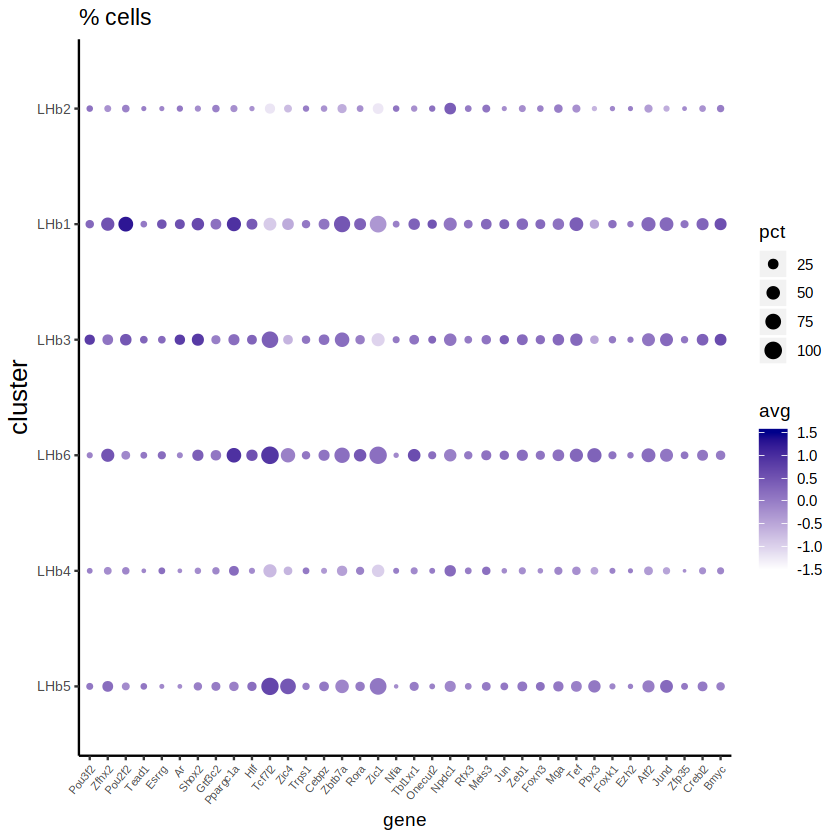

In [18]:
ggplot(Cell_number, aes(gene, cluster)) + geom_point(aes(size = pct, colour=avg)) + 
scale_color_gradient(low = "white", high = "darkblue",limits = c(-1.5,1.5),oob=squish) + 
geom_point(aes(size = pct), pch=21,, lwd=0,stroke=0)+ scale_size_continuous(range = c(0,3.9))+
theme(axis.title.y=element_text(size=15),axis.text.y=element_text(size=8),axis.text.x=element_text(size=6,angle = 50, hjust = 1),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))+ggtitle("% cells")
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/discplots_TF_LHb.pdf",height=4, width=10 , paper = "letter")